#EECS 504 PS3: Motion Magnification and Texture Synthesis

Please provide the following information 
(e.g. Andrew Owens, ahowens):

[PoKang] [Chen], [pkchen]




# Starting

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells and save the notebook to your local machine as a .ipynb file for Canvas submission.

In [0]:
%matplotlib inline
import numpy as np
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from numpy import angle, real
from numpy import exp, abs, pi, sqrt
import matplotlib.pyplot as plt
import cv2
import math

import random
import sys
from scipy import ndimage
from PIL import Image, ImageChops

# cv2.imshow does not work in Colab, we use cv2_imshow instead
from google.colab.patches import cv2_imshow

In [0]:
%%capture
#download some imagesshould take a second to run

#for motion magnification problem
! wget -O bill.avi "https://drive.google.com/uc?export=download&id=1QR2dCShn-fYYEvcAQ8J4mnIo_ISqrjc7"

# for texture synthesis problem
! wget -O texture.jpg "https://drive.google.com/uc?export=download&id=11IlTZNLwfYsXQt2L1GbKdNqcj6JNkQik"
! wget -O rings.jpg "https://drive.google.com/uc?export=download&id=1fYtmQe_a40BWg1OU178SFbcU4KRZuphn"
! wget -O jigsaw.jpg "https://drive.google.com/uc?export=download&id=1SlYUw6vT9_PNP8XNhQfAu36AtPJ-PMpk"

# For own picture
! wget -O brick_resize.jpg "https://drive.google.com/uc?export=download&id=1JkPaJdc15oTSLYWdzqjlPUla36Mqjbyn"
! wget -O brick2_resize.jpg "https://drive.google.com/uc?export=download&id=14Ht4WGY5w6_iZGrGemMcz58Qs0MNopk5"

## **Problem 3.1 (a)**

In [0]:
def imshow(im, cmap='gray'):
    # clip image from 0-1
    im = np.clip(im, 0, 1)
    plt.imshow(im, cmap=cmap)

In [0]:
# 9x9 images
im_size = 9

# we would like to magnify the change between im1 and im2 by 4x
magnification_factor = 4;

# horizontal movement from (0, 0) to (0, 1)
im1 = np.zeros([im_size, im_size])
im2 = np.zeros([im_size, im_size])
im1[0,0] = 1
im2[0,1] = 1

ff1 = fftshift(fft2(im1))
ff2 = fftshift(fft2(im2))



### This is a quick tutorial for those who are not familiar with complex numbers in python.

In [14]:
# create a complex number
x = 1 + 1j
print("x =", x)
print("x.real", x.real, "x.imag", x.imag)

# magnitude and phase of complex number
mag = abs(x)
phase = angle(x)

print("Magnitude", mag)
print("Phase", phase)

# Euler's formula
y = mag * exp(phase * 1j)
print("y =", y)

x = (1+1j)
x.real 1.0 x.imag 1.0
Magnitude 1.4142135623730951
Phase 0.7853981633974483
y = (1.0000000000000002+1j)


In [0]:
def magnify_change(im1, im2, magnification_factor):
    
    # find phase shift in frequency domain
    im1_dft = fft2(im1)
    im2_dft = fft2(im2)
    # phase_shift = np.subtract(angle(im1_dft),angle(im2_dft))
    phase_shift = angle(im2_dft) - angle(im1_dft)

    # magnify the phase change in frequency domain 
    magnified_dft = phase_shift * magnification_factor
    magnified = abs(im1_dft) * exp((angle(im1_dft) + magnified_dft) * 1j) # abs(one of the image) * exp((origin_angle + magphase) * 1j)
    # what does the magnified phase change cause in image space?
    magnified = ifft2(magnified).real  #For plotting
    
    return magnified

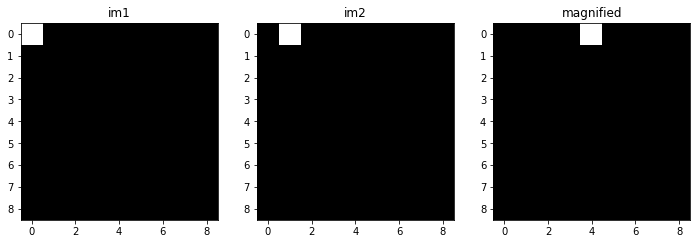

In [16]:
# magnify position change
magnified = magnify_change(im1, im2, magnification_factor);

plt.figure(figsize=(12,36))
plt.subplot(131)
imshow(im1); plt.title('im1');

plt.subplot(132)
imshow(im2); plt.title('im2');

plt.subplot(133)
imshow(magnified); plt.title('magnified');

## **Problem 3.1 (b)**


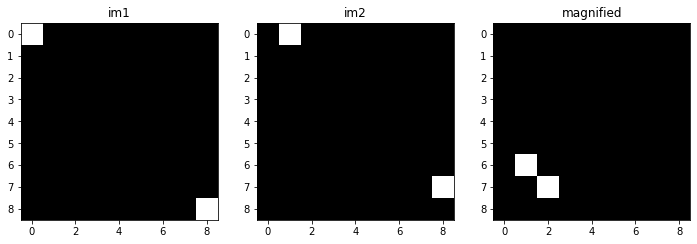

In [17]:
# 9x9 images
im_size = 9

# we would like to magnify the change between im1 and im2 by 4x
magnification_factor = 4

# horizontal movement from (0, 0) to (0, 1)
# additional vertical movement from (8, 8) to (7, 8)
im1 = np.zeros([im_size, im_size])
im2 = np.zeros([im_size, im_size])
im1[0,0] = 1
im2[0,1] = 1
im1[8,8] = 1
im2[7,8] = 1

# magnify position change
magnified = magnify_change(im1, im2, magnification_factor)


plt.figure(figsize=(12,36))
plt.subplot(131)
imshow(im1); plt.title('im1');

plt.subplot(132)
imshow(im2); plt.title('im2');

plt.subplot(133)
imshow(magnified); plt.title('magnified');


The reason it is not properly magnified is that_____. 

## **Problem 3.1 (c)**


Text(0.5, 1.0, 'magnified')

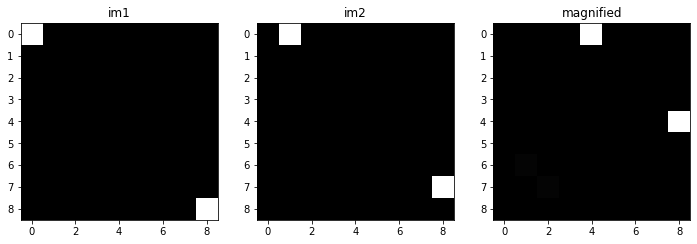

In [18]:
#The Gaussian mask we want you to create will be of the same size as the original image.
#We will be sliding the center of the Gaussian distribution across the mask, from the left top to the bottom right. 
#By multiplying such a mask with the original image, we can filter local information for motion magnification.
import scipy.stats as st
# 9x9 images
im_size = 9

# we would like to magnify the change between im1 and im2 by 4x
magnification_factor = 4

# width of our Gaussian window
sigma = 2

def matlab_style_gauss2D(shape,sigma):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h
def gkern(kernlen=21, nsig=3):
    """Returns a 2D Gaussian kernel."""

    x = np.linspace(-nsig, nsig, kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    return kern2d/kern2d.sum()

# horizontal movement from (0, 0) to (0, 1)
# additional vertical movement from (8, 8) to (7, 8)
im1 = np.zeros([im_size, im_size])
im2 = np.zeros([im_size, im_size])
im1[0,0] = 1
im2[0,1] = 1
im1[8,8] = 1
im2[7,8] = 1

# we will magnify windows of the image and aggregate the results
magnified = np.zeros([im_size, im_size])

# meshgrid for computing Gaussian window
X, Y = np.meshgrid(np.arange(im_size), np.arange(im_size))

for y in range(0, im_size, 2*sigma):
    for x in range(0, im_size, 2*sigma):
        # gaussian_mask = matlab_style_gauss2D((im_size,im_size) , sigma)
        gaussian_mask = np.exp(-0.5 * (np.square(X - x) + np.square(Y - y)) / np.square(sigma))
        window_magnified = magnify_change(im1 * gaussian_mask, im2 * gaussian_mask, magnification_factor) #  magnified the difference and output image
        magnified = magnified + window_magnified
      
        
plt.figure(figsize=(12,36))
plt.subplot(131)
imshow(im1); plt.title('im1');

plt.subplot(132)
imshow(im2); plt.title('im2');

plt.subplot(133)
imshow(magnified); plt.title('magnified')

## **Problem 3.1 (d) - Motion Magnification**


In [19]:
import numpy as np
import cv2

cap = cv2.VideoCapture('bill.avi')

# list of video frames
frames = []

while(cap.isOpened()):
    # read frame from the video
    ret, frame = cap.read()
    
    if ret is False:
        break

    frame = cv2.resize(frame, (200, 200), interpolation=cv2.INTER_CUBIC)
    frames.append(frame)

cap.release()

# scale frame to 0-1
frames = np.array(frames) / 255.
print("frames size:", frames.shape, "# (nb_frames, height, width, channel)")

# get height, width
num_frames = frames.shape[0]
height = frames.shape[1]
width = frames.shape[2]

frames size: (60, 200, 200, 3) # (nb_frames, height, width, channel)


In [20]:
# 10x magnification of motion
magnification_factor = 10

# width of Gaussian window
sigma = 26

# alpha for moving average
alpha = 0.5

# we will magnify windows of the video and aggregate the results
magnified = np.zeros_like(frames)

# meshgrid for computing Gaussian window
X, Y = np.meshgrid(np.arange(width), np.arange(height))

# iterate over windows of the frames
x_range = list(range(0, width, 2*sigma))
y_range = list(range(0, height, 2*sigma))
num_windows = len(x_range) * len(y_range)
window_index = 1

for y in y_range:
    for x in x_range:
        for channel_index in range(3): # RGB channels
            for frame_index in range(num_frames):
                
                # create windowed frames
                gaussian_mask = np.exp(-0.5 * (np.square(X - x) + np.square(Y - y)) / np.square(sigma)) #TODO5
                windowed_frames = gaussian_mask * frames[frame_index,:,:,channel_index]
            
                # initialize moving average of phase for current window/channel
                if frame_index == 0:
                    window_average_phase = angle(fft2(windowed_frames))
                
                window_dft = fft2(windowed_frames)
                
                # compute phase shift and constrain to [-pi, pi] since
                # angle space wraps around
                window_phase_shift = angle(window_dft) - window_average_phase
                window_phase_shift[window_phase_shift > pi] = window_phase_shift[window_phase_shift > pi] - 2 * pi
                window_phase_shift[window_phase_shift < -pi] = window_phase_shift[window_phase_shift < -pi] + 2 * pi
                
                # magnify phase shift
                window_magnified_phase = window_phase_shift * magnification_factor #TODO6

                # go back to image space
                window_magnified_dft = window_dft * exp(window_magnified_phase * 1j)#TODO7 not sure
                window_magnified = abs(ifft2(window_magnified_dft))
                
                # update moving average
                window_phase_unwrapped = window_average_phase + window_phase_shift
                window_average_phase = alpha * window_average_phase + (1 - alpha) * window_phase_unwrapped
                
                # aggregate
                magnified[frame_index,:,:,channel_index] = magnified[frame_index,:,:,channel_index] + window_magnified
        
        # print progress
        print('{}/{}'.format(window_index, num_windows))
        window_index += 1

1/16
2/16
3/16
4/16
5/16
6/16
7/16
8/16
9/16
10/16
11/16
12/16
13/16
14/16
15/16
16/16


In [0]:
outputs = magnified / np.max(magnified)
for channel_index in range(3):
    original_frame = frames[0,:,:,channel_index]
    magnified_frame = outputs[0,:,:,channel_index]
    scale = np.std(original_frame[:]) / np.std(magnified_frame[:])
    original_mean = np.mean(original_frame[:])
    magnified_mean = np.mean(magnified_frame[:])
    outputs[:,:,:,channel_index] = magnified_mean + scale * (outputs[:,:,:,channel_index] - magnified_mean)

outputs = np.clip(outputs, 0, 1)

In [0]:
# create output video
fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
# fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('bill_magnified.avi',fourcc, 30.0, (height, width))

for i in range(frames.shape[0]):
    # scale the frame back to 0-255
    frame = (np.clip(outputs[i], 0, 1) * 255).astype(np.uint8)
    
    # write frame to output video
    out.write(frame)

out.release()

In [0]:
# Only for colab downloading videos
try:
    from google.colab import files
    files.download('bill_magnified.avi')
except:
    print("Only for google colab")

## **Problem 3.2 - Texture Synthesis**

Note that the functions provided below are templates. Feel free to add your own helper functions as needed.

You can reference the pseudocode provided here:  https://people.eecs.berkeley.edu/~efros/research/NPS/alg.html.

### Find matches function

In [0]:
import scipy.ndimage

def find_matches(template, sample, gauss_mask): 
    # print(template.shape[0])
    # print(template.shape[1])

#template = window of size w*w from the target image
#sample = source texture image
#gauss_mask = 2D Gaussian mask
    ### parameters, as used by Efros and Leung
    epsilon = 0.1 #ErrThreshold
    delta = 0.3 #MaxErrThreshold
    w = template.shape[0]
    #### TODO:
    # valid_mask is a square mask of width window_size that is 1 where template is filled
    valid_mask = np.zeros((w , w))
    for i in range(w):
      for j in range(w):
        for k in range(3):
          if (template[i , j , k] != 0 ):
            valid_mask[ i , j] = 1

    mask = np.multiply( gauss_mask , valid_mask )       #elementwise multiplication

    #### TODO:
    # vectorized code that calculates SSD(template, sample)*mask for all patches
    SSD_size = sample.shape[0] - w // 2 *2
    SSD = np.zeros((SSD_size , SSD_size))
    for i in range(SSD_size):
      for j in range(SSD_size):
        dis = np.sum( np.square( mask[..., np.newaxis] * (template - sample[i : i + w  , j : j + w , :])  ) )
        SSD[i,j] = dis
    
    SSD = SSD / np.sum(SSD) #normalized SSD
    best_matches = []
    for i in range(SSD.shape[0]):
      for j in range(SSD.shape[0]):
        if SSD[i , j] <= np.min(SSD) * (1 + epsilon):
          best_matches.append((i + w//2 ,j + w//2))
    # print(best_matches)
    return best_matches #list of candidate matches in the source texture along with their corresponding SSD errors.

### Synthesize texture function

In [0]:
def dnorm(x, mu, sd):
    return 1 / (np.sqrt(2 * np.pi) * sd) * np.e ** (-np.power((x - mu) / sd, 2) / 2)
def gaussian_kernel(size, sigma=2, verbose=False):
 
    kernel_1D = np.linspace(-(size // 2), size // 2, size)
    for i in range(size):
        kernel_1D[i] = dnorm(kernel_1D[i], 0, sigma)
    kernel_2D = np.outer(kernel_1D.T, kernel_1D.T)
 
    kernel_2D *= 1.0 / kernel_2D.max()
 
    if verbose:
        plt.imshow(kernel_2D, interpolation='none',cmap='gray')
        plt.title("Image")
        plt.show()
    
    return kernel_2D/kernel_2D.sum()
kernel = gaussian_kernel(11, sigma=2, verbose=False) #size of 11,2

def synth_texture(sample, window_size, out_size):
    # normalize pixel intensity
    sample = sample.astype(np.float64)
    sample = sample / 255.0
    seed_size = 3 
    [sheight, swidth, channels] = sample.shape # 34 * 34 * 3
    synth_img = np.zeros((*out_size, channels))

    # initialization: pick a random 3x3 patch from sample and place in the middle of the synthesized image
    rh = round(seed_size + np.random.uniform(0,1) * (sheight - 2 * seed_size))
    rw = round(seed_size + np.random.uniform(0,1) * (swidth - 2 * seed_size))
    center = [round(.5 * x) for x in out_size] # center
    synth_img[center[0]: center[0] + seed_size, center[1]: center[1] + seed_size ,:] = sample[rh: rh + seed_size , rw: rw + seed_size,:] #Fill in the initialization patch

    # bitmap indicating filled pixels, the seed patch is initially filled
    filled = np.zeros(out_size)
    filled[center[0]: center[0] + seed_size , center[1]: center[1] + seed_size] = 1 #Fill in the location where filled map is occupied
    num_filled = int(np.sum(filled)) # number of place that has been filled
    n_pixels = out_size[0] * out_size[1] #10000

    #Padding
    P = window_size // 2
    synth_img = cv2.copyMakeBorder(synth_img,P,P,P,P,cv2.BORDER_CONSTANT,0)

    ######### TODO
    # intialize 2D zero-mean gaussian w/ variance = (window_size / 6.4)
    # X, Y = np.meshgrid(np.arange(swidth), np.arange(sheight))
    sigma = window_size / 6.4
    # G = np.ones((window_size,window_size))
    # gaussian_mask = scipy.ndimage.gaussian_filter(G,sigma)
    gaussian_mask = gaussian_kernel(window_size, sigma=2, verbose=False)
    # print(gaussian_mask)
    # gaussian_mask = np.exp(-0.5 * (np.square(X) + np.square(Y)) / np.square(sigma))

    # main loop: repeat until all pixels are filled
    next_p = n_pixels / 10  #10000/10 = 1000
    while(num_filled < n_pixels):
        # report progress
        if(num_filled > next_p):
            print(round(100 * num_filled / n_pixels), '% complete')
            next_p += n_pixels / 10

        # TODO:
        # get list of unfilled pixels as (x, y) coordinates
        # hint: use dilation and masking to efficiently find unfilled neighboring pixels
        struct2 = ndimage.generate_binary_structure(2, 2)
        dilation = ndimage.binary_dilation(filled, structure = struct2).astype(filled.dtype) - filled
        pixel_list = [(i,j) for i in range(dilation.shape[0]) for j in range(dilation.shape[1]) if dilation[i,j] == 1 ]
        # print(pixel_list)
        # TODO:
        # (optional, but recommended) randomly permute and sort list of pixels decreasing number of filled neighbor pixels

        # TODO:
        # iterate over the list of pixels
        template = np.zeros((window_size, window_size, window_size))
        for x, y in pixel_list: #x,y is the position in synth_img where it's going to place the patch
          # TODO:
          # place window with center as (x, y) and use as template
          p = window_size //2
          template = synth_img[(x+p) - window_size //2 : (x+p) + window_size//2 + 1 , (y+p) - window_size //2 : (y+p) + window_size//2 + 1 , :]
          # TODO:
          # find the best matching windows from sample image
          # randomly sample one from best matches
          Bestmatches = find_matches(template , sample, gaussian_mask) #x,y coordinate of small value in SSD with range s - w//2 * 2
          Bestmatch = Bestmatches[np.random.randint(0,np.abs(len(Bestmatches)))]
          # Bestmatch = Bestmatches[0] ####
          synth_img[x + p , y + p, :] = sample[Bestmatch[0], Bestmatch[1] , :] #### + ppppp
          filled[x,y] = 1
          # if (BestMatch.error < MaxErrThreshold) then
          #   Pixel.value = BestMatch.value
        num_filled = int(np.sum(filled)) 
    p = window_size //2 
    synth_img = synth_img * 255
    synth_img = synth_img[p : synth_img.shape[0] - p, p : synth_img.shape[0] - p]
    return synth_img

In [8]:
import numpy

array = numpy.array([[1 ,1, 0], [0, 1, 0], [0, 0, 0]]) 

print("Printing 2D Array")
print(array)

pixel_list = [(i,j) for i in range(array.shape[0]) for j in range(array.shape[1]) if array[i,j] == 1 ]
# array = cv2.copyMakeBorder(array,3,3,3,3,cv2.BORDER_CONSTANT,0)
print("pixel list",pixel_list)

print("Choose random row from 2D array")
randomRow = numpy.random.randint(3, size=1)
print(array[randomRow,:])


Printing 2D Array
[[1 1 0]
 [0 1 0]
 [0 0 0]]
pixel list [(0, 0), (0, 1), (1, 1)]
Choose random row from 2D array
[[0 1 0]]



### Main function

Run the texture synthesis algorithm to generate texture of new shape. 

Source Image


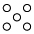

11 % complete
20 % complete
30 % complete
42 % complete
50 % complete
62 % complete
72 % complete
83 % complete
90 % complete
Target Image


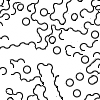

11 % complete
20 % complete
30 % complete
42 % complete
50 % complete
62 % complete
72 % complete
83 % complete
90 % complete
Target Image


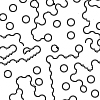

11 % complete
20 % complete
30 % complete
42 % complete
50 % complete
62 % complete
72 % complete
83 % complete
90 % complete
Target Image


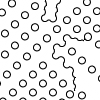

Source Image


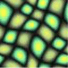

11 % complete
20 % complete
30 % complete
42 % complete
50 % complete
62 % complete
72 % complete
83 % complete
90 % complete
Target Image


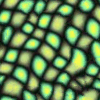

Source Image


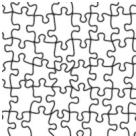

11 % complete
20 % complete
30 % complete
42 % complete


In [0]:
# np.seterr(divide='ignore', invalid='ignore') ##error for dividing errors
# Texture synthesis on rings
source = cv2.imread('rings.jpg')
# print(source.shape) #34 , 34, 3
window_sizes = [5, 7, 13] 
out_size = [100, 100]

print('Source Image')
cv2_imshow(source)

for w in window_sizes:
  target = synth_texture(source, w, out_size)
  print('Target Image')
  cv2_imshow(target)

w = 5
# Texture synthesis on colored image
source = cv2.imread('texture.jpg')
print('Source Image')
cv2_imshow(source)
target = synth_texture(source, w, out_size)
print('Target Image')
cv2_imshow(target)

# Don't need to submit this one
source = cv2.imread('jigsaw.jpg')
print('Source Image')
cv2_imshow(source)
target = synth_texture(source, w, out_size)
print('Target Image')
cv2_imshow(target)

Q:
Explain the algorithm’s performance with respect to window size. For a given window size, if you re-run the algorithm with the same starting seed do you get the same result? Why or why not? Is this true for all window sizes? Also run your implementation using real color image texture.jpg and see how window size affects the performance. 

A:
As the window size is getting bigger, it takes more time to run. The reason is that it takes more time to go through the block. Also, same starting seed wouldn’t always result in same result. Because there’s random pick within. Also if  the window is bigger, it'll take more time for that but the performance will be better. 

Source Image


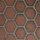

11 % complete
20 % complete
30 % complete
42 % complete
50 % complete
62 % complete
72 % complete
83 % complete
90 % complete
Target Image


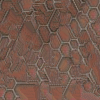

In [44]:
# Own picture
source = cv2.imread('brick2_resize.jpg')
w = 11
print('Source Image')
cv2_imshow(source)
target = synth_texture(source, w, out_size)
print('Target Image')
cv2_imshow(target)